In [5]:
import pandas as pd
import numpy as np

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

from tqdm import notebook

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SVMSMOTE

from catboost import CatBoostClassifier

from joblib import dump


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dtata\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
df = pd.read_csv('test.csv')
df.drop(['id', 'mkb'], axis=1, inplace=True)

In [7]:
features, target = df.drop('target', axis=1), df['target']
features_train, features_test, target_train, target_test = train_test_split(
    features, target, stratify=target, test_size=0.25, random_state=42)

In [61]:
numerical = ['height', 'weight', 'bmi', 'bsa', 'age', 
             'days_in_hospital', 'fv', 'lg_kdr_size', 
             'dmgp', 'ekg_qrs', 'ekg_qrst', 'ekg_pq', 'total']
num_pipe = Pipeline([('scaler', StandardScaler())])

categorical = ['pg_big', 'ekg_eos'] # 'mkb'
cat_pipe = Pipeline([('ohe', OneHotEncoder())])

stop_words = list(stopwords.words('russian')) 
text = ['diagnosis', 'medication_main', 'medications_taken']

tree_preprocessor = ColumnTransformer(
    transformers = [(x, TfidfVectorizer(stop_words=stop_words), x) for x in text] + \
                   [('cat', cat_pipe, categorical)],
    remainder='passthrough')

# предобработка признаков
tree_preprocessor.fit(features_train)


### Catboost с встроенной предобработкой. Исходный вариант модели

In [ ]:
# class_weights= dict(zip(np.unique(target_train), 
#                         compute_class_weight(class_weight='balanced', 
#                                              classes=np.unique(target_train), 
#                                              y=target_train)))

# class_weights= {0: 0.53038936, 1: 8.7265625} 

In [62]:
%%time

cat_clf = Pipeline([('preprocessor', tree_preprocessor),
                    ('svm', SVMSMOTE(random_state=42)),
                    ('model', CatBoostClassifier(depth=10, iterations=200,
                                                 class_weights={0: 0.53038936, 1: 8.7265625}, 
                                                 silent=True, random_seed=42))])


cat_clf.fit(features_train, target_train)

# сохранение модели
# dump(cat_clf, 'model.joblib')

CPU times: total: 11min 16s
Wall time: 1min 2s


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('diagnosis',
                                                  TfidfVectorizer(stop_words=['и',
                                                                              'в',
                                                                              'во',
                                                                              'не',
                                                                              'что',
                                                                              'он',
                                                                              'на',
                                                                              'я',
                                                                              'с',
                                                                              'со',
                                                                              'как',
                                                                              'а',
                                                                              'то',
                                                                              'все',
                                                                              'она',
                                                                              'так',
                                                                              'его',
                                                                              'но',
                                                                              'да',
                                                                              'ты',
                                                                              'к',
                                                                              'у',
                                                                              'же',
                                                                              'вы',
                                                                              'за',
                                                                              'бы',
                                                                              'по',
                                                                              'только',
                                                                              'ее',
                                                                              'мне', ...]),
                                                  'diagnosis'),
                                                 ('medication_main',
                                                  TfidfVectorizer(stop_words=['...
                                                                              'во',
                                                                              'не',
                                                                              'что',
                                                                              'он',
                                                                              'на',
                                                                              'я',
                                                                              'с',
                                                                              'со',
                                                                              'как',
                                                                              'а',
                                                                              'то',
                                                                              'все',
                                                                              'она',
    

array([[0.96560336, 0.03439664],
       [0.97384721, 0.02615279],
       [0.96782956, 0.03217044]])

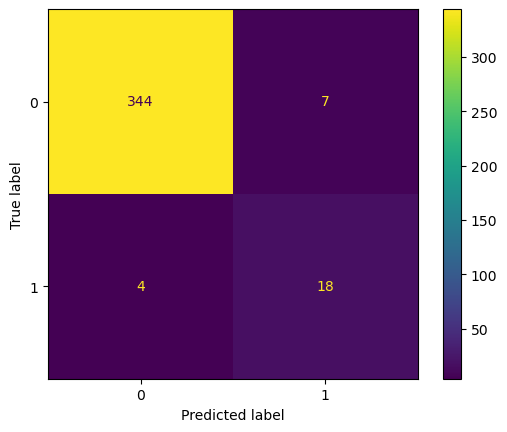

In [6]:
# Тест

ConfusionMatrixDisplay(confusion_matrix(target_test,  cat_clf.predict(features_test))).plot();

predict = cat_clf.predict(features_test[:3])
predict_proba = cat_clf.predict_proba(features_test[:3])
predict_proba

```python
print('Результаты подбора параметров.\n')
print('Совокупная точность:', (18/22+344/351)/2)
print(f'Время подбора параметров: {round(cat_gs_time // 60, 2)} мин')
print(f'Время обучения модели: {round(cat_gs.cv_results_["mean_fit_time"][cat_gs.best_index_], 5)} сек')
print(f'Время предсказания модели: {round(cat_gs.cv_results_["mean_score_time"][cat_gs.best_index_], 5)} сек')
print(f'Качество модели по кросс-валидации: {cat_gs.best_score_}')
print(f'Лучшие значения параметров: {cat_gs.best_params_}')
print(classification_report(target_test, cat_gs.best_estimator_.predict(features_test)))
```
```
Результаты подбора параметров.

Совокупная точность: 0.8991193991193991
Время подбора параметров: 4.0 мин
Время обучения модели: 89.99023 сек
Время предсказания модели: 0.06881 сек
Качество модели по кросс-валидации: 0.38
Лучшие значения параметров: {'model__depth': 10, 'model__iterations': 200}
    
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       351
           1       0.69      0.82      0.75        22

    accuracy                           0.97       373
   macro avg       0.84      0.90      0.87       373
weighted avg       0.97      0.97      0.97       373
```

### Catboost без встроенной предобработки. Новый вариант модели

На тот случай, елси нужно отделять предобработку от модели.

In [65]:
%%time

cat_clf_without_preprocessor = Pipeline([('sampling', SVMSMOTE(random_state=42)),
                                         ('model', CatBoostClassifier(depth=10, iterations=200,
                                                                      class_weights={0: 0.53038936, 1: 8.7265625},
                                                                      silent=True, random_seed=42))])
transform_data = Pipeline([('preprocessor', tree_preprocessor)])

# Обучение модели
features_train = transform_data.transform(features_train)
cat_clf_without_preprocessor.fit(features_train, target_train)

# сохранение модели
#dump(cat_clf_without_preprocessor, 'model_without_preprocessor.joblib')

CPU times: total: 11min 16s
Wall time: 1min 2s


['model_without_preprocessor.joblib']

In [1]:
# Программа. Алгоритм предобработки и прогноза
text = '''
# Функция предобработки сырых данных, вызов модели, возвращение прогноза
def predict_proba(features):
    import pickle
    from imblearn.pipeline import Pipeline
    from joblib import load

    # Загрузка модели из файла с помощью функции load
    model = load('model_without_preprocessor.joblib')

    # Загрузка сохраненного препроцессора из файла
    with open('tree_preprocessor.pkl', 'rb') as file:
        tree_preprocessor = pickle.load(file)
    transform_data = Pipeline([('preprocessor', tree_preprocessor)])
    features_test = transform_data.transform(features)

    return model.predict_proba(features_test)[0][1]
'''
# сохранение
with open('model_without_preprocessor.py', 'w+', encoding="utf-8",) as f:  
    f.write(text.strip()) 

In [8]:
import model_without_preprocessor

model_without_preprocessor.predict_proba(features_test)

0.03439664281517697

# requirements.txt

In [7]:
pip freeze

absl-py==1.4.0
aiohttp==3.8.4
aiosignal==1.3.1
alabaster @ file:///home/ktietz/src/ci/alabaster_1611921544520/work
altair==4.2.2
anaconda-client==1.11.1
anaconda-navigator==2.4.0
anaconda-project @ file:///C:/Windows/TEMP/abs_91fu4tfkih/croots/recipe/anaconda-project_1660339890874/work
anyio @ file:///C:/ci/anyio_1644481856696/work/dist
appdirs==1.4.4
argon2-cffi @ file:///opt/conda/conda-bld/argon2-cffi_1645000214183/work
argon2-cffi-bindings @ file:///C:/ci/argon2-cffi-bindings_1644569876605/work
arrow @ file:///C:/b/abs_cal7u12ktb/croot/arrow_1676588147908/work
astroid @ file:///C:/b/abs_d4lg3_taxn/croot/astroid_1676904351456/work
astropy @ file:///C:/ci/astropy_1657719642921/work
asttokens @ file:///opt/conda/conda-bld/asttokens_1646925590279/work
astunparse==1.6.3
async-timeout==4.0.2
atomicwrites==1.4.0
attrs @ file:///C:/b/abs_09s3y775ra/croot/attrs_1668696195628/work
Automat @ file:///tmp/build/80754af9/automat_1600298431173/work
autopep8 @ file:///opt/conda/conda-bld/autopep8_